In [1]:
import pennylane as qml

H = qml.Hamiltonian(
    [1,1,0.5],
    [qml.PauliX(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]
)
print(H)

  (1) [X0]
+ (1) [Z1]
+ (0.5) [X0 X1]


In [2]:
dev = qml.device('default.qubit', wires = 2)

t = 1
n = 2

@qml.qnode(dev)
def circuit():
    qml.ApproxTimeEvolution(H, t, n)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit, expansion_strategy='device')())

0: ──RX(1.00)─╭RXX(0.50)──RX(1.00)─╭RXX(0.50)─┤  <Z>
1: ──RZ(1.00)─╰RXX(0.50)──RZ(1.00)─╰RXX(0.50)─┤  <Z>


In [3]:
def circ(theta):
    qml.RX(theta, wires = 0)
    qml.Hadamard(wires = 1)
    qml.CNOT(wires = [0,1])

@qml.qnode(dev)
def circuit(param):
    circ(param)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)(0.5))

0: ──RX(0.50)─╭●─┤  <Z>
1: ──H────────╰X─┤  <Z>


In [4]:
@qml.qnode(dev)
def circuit(params, **kwargs):
    qml.layer(circ, 3, params)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)([0.3, 0.4, 0.5]))

0: ──RX(0.30)─╭●──RX(0.40)─╭●──RX(0.50)─╭●─┤  <Z>
1: ──H────────╰X──H────────╰X──H────────╰X─┤  <Z>


# QAOA
1. Define a cost Hamiltonian $H_C$ such that its ground state encodes the solution to the optimization problem
2. Define a mixer Hamiltonian $H_M$
3. Construct the circuits $e^{-i \gamma H_M}$ and $e^{-i \alpha H_M}$. We call these the cost and mixer layers, respectively.
4. Choose a  parameter $n \ge 1$ and build the circuit $$ U(\gamma,\alpha) =  e^{-i \gamma H_M}e^{-i \alpha H_M} ... e^{-i \gamma H_M}e^{-i \alpha H_M},$$ consisting of repeated application of the cost and mixer layers.
5. Prepare an initial state, apply $U(\gamma,\alpha)$, and use classical techniques to optimize the parameters.
6. After the circuit has been optimized, measurements of the output state reveal approximate solutions to the optimization problem.

In [5]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

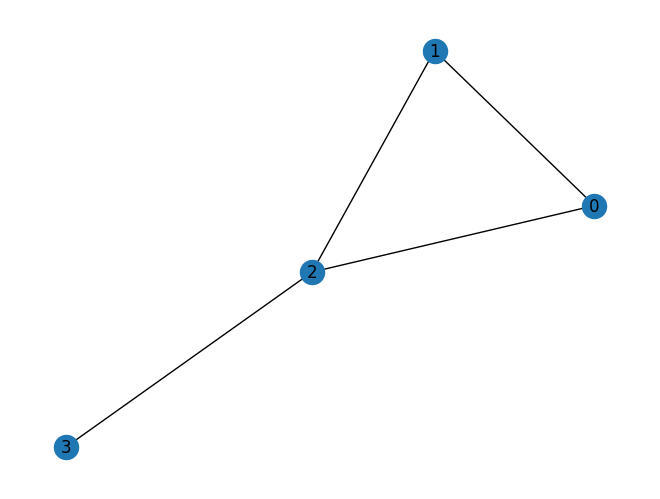

In [6]:
edges = [(0, 1), (1, 2), (2,0), (2,3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

In [7]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost", cost_h)
print("Mixer", mixer_h)

Cost   (-0.25) [Z3]
+ (0.5) [Z0]
+ (0.5) [Z1]
+ (1.25) [Z2]
+ (0.75) [Z0 Z1]
+ (0.75) [Z0 Z2]
+ (0.75) [Z1 Z2]
+ (0.75) [Z2 Z3]
Mixer   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


In [8]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [9]:
wires = range(4)
depth = 2


def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [10]:
dev = qml.device("qulacs.simulator", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

In [11]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

In [12]:
for i in range(steps):
    params = optimizer.step(cost_function,params)

print(params)

[[0.59806352 0.94198485]
 [0.52797281 0.85552845]]


In [13]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma,alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

In [14]:
#print(plt.style.available)

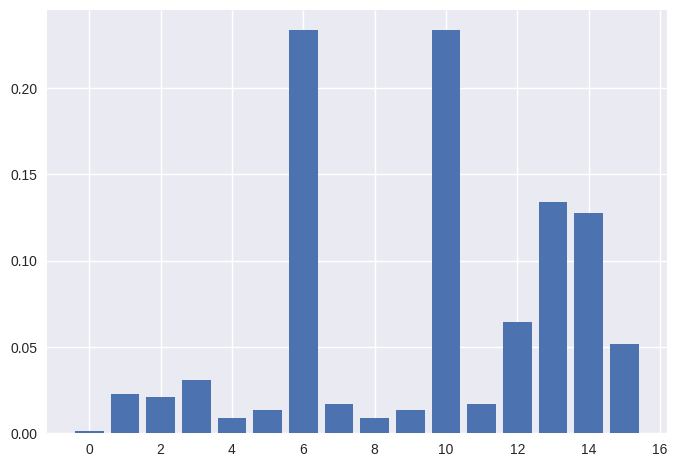

0: ──H─╭ApproxTimeEvolution(0.75,0.50,0.50,0.75,1.25,0.75,0.75,-0.25,0.60)
1: ──H─├ApproxTimeEvolution(0.75,0.50,0.50,0.75,1.25,0.75,0.75,-0.25,0.60)
2: ──H─├ApproxTimeEvolution(0.75,0.50,0.50,0.75,1.25,0.75,0.75,-0.25,0.60)
3: ──H─╰ApproxTimeEvolution(0.75,0.50,0.50,0.75,1.25,0.75,0.75,-0.25,0.60)

──╭ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.53)
──├ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.53)
──├ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.53)
──╰ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.53)

──╭ApproxTimeEvolution(0.75,0.50,0.50,0.75,1.25,0.75,0.75,-0.25,0.94)
──├ApproxTimeEvolution(0.75,0.50,0.50,0.75,1.25,0.75,0.75,-0.25,0.94)
──├ApproxTimeEvolution(0.75,0.50,0.50,0.75,1.25,0.75,0.75,-0.25,0.94)
──╰ApproxTimeEvolution(0.75,0.50,0.50,0.75,1.25,0.75,0.75,-0.25,0.94)

──╭ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.86)─┤  
──├ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.86)─┤  
──├ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.86)─┤  
──╰ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.86)─┤  


In [15]:
plt.style.use("seaborn-v0_8")
plt.bar(range(2**len(wires)),probs)
plt.show()
print(qml.draw(circuit)([params[0],params[1]]))

In [25]:
wires = range(4)
depth = 2
@qml.transforms.to_zx
def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [40]:
import pyzx as zx

dev = qml.device('default.qubit', wires = 4)

g = circuit(params)
print(g.depth())
zx.draw(g)
graph = zx.extract_simple(g).to_graph()
#zx.settings.tikzit_location = "/usr/bin/tikzit"
#zx.tikz.tikzit(graph)

34


Opening Tikzit...


Attribute Qt::AA_EnableHighDpiScaling must be set before QCoreApplication is created.
2


Done


In [27]:
zx.simplify.id_simp(g)
zx.simplify.spider_simp(g)
#zx.simplify.id_simp(g)
zx.simplify.interior_clifford_simp(g)

id_simp: 20.  1 iterations
spider_simp: 8. 6. 2.  3 iterations
spider_simp: 6. 1.  2 iterations


1

In [28]:
g.normalize()
zx.draw(g)

In [29]:
res = zx.extract_circuit(g.copy(), optimize_cnots=3).to_basic_gates()

In [30]:
zx.draw(res)

In [32]:
fr_graph = res.to_graph()
# Simple simplifications
zx.spider_simp(fr_graph,quiet=False)
zx.id_simp(fr_graph,quiet=False)
zx.to_rg(fr_graph)
#The simps above dont change the graph too much so we can use the extract_simple
fr_opt = zx.extract_simple(fr_graph)
print()
#print(fr_opt.stats(),)#"\nEQUAL: " , g.verify_equality(fr_opt))
draw(fr_opt)

spider_simp: 18. 15. 11. 8. 2. 1.  6 iterations
id_simp: 4.  1 iterations



In [33]:
fr_opt.depth()

27